# Read Me

Las datos de [entranamiento](https://drive.google.com/file/d/1tfo6qm8zB5Eb7TY8WQGey-SqwBiC-3uO/view?usp=sharing) y [prueba](https://drive.google.com/file/d/1--yMo6lHVrkU9iqXUjLIJpKLYaz7QfLF/view?usp=sharing) fueron descargados de la plataforma [zoo galaxy](https://data.galaxyzoo.org/#section-21) correspondientes al Galaxy Zoo 2 ([images_gz2.zip](https://zenodo.org/records/3565489#.Y3vFKS-l0eY)).
Dichos datos estan almacenados ya como ".h5" en lugar del formato original de ".jpg" para faciliar el manejor de los mismos.
Se tratan de 10,000 archivos para entrenar y 5,000 archivos probar al modelo.
Dichos archivos contienen la información de los 539,328 (424x424x3) pixeles de la imagen ".jpg" original.

Esto dada una cantidad inmanejable de datos (aprox 5$\times$10$^9$ pixeles para entrenar), por lo que es necesario reducir las dimeniones de los datos

Para logar esta redución de dimesiones, primero se tuvo que recortar las imagenes originales para reducir la cantidad de foto y darle más enfasis a la galaxia, luego se entreno un modelo IPCA, pasando de (174,174,3) a (5,5,3). Además de Esta disminusión se entreno otro modelo para aprender a rescalar los valores para poder aplicar k-means sin problema. Ambos modelos estan [disponibles](https://drive.google.com/drive/folders/1ZlEGFbrwHGSR0QaGgP5GbO-JOjR5FX9b?usp=sharing).

En un intento de aguilizar la carga de los datos los datos de etranamiento y prueba procesador por los modelos de IPCA y SCALER se opto por guardarlos como archivos ".pkl". Ambos archivos estan [disponibles](https://drive.google.com/drive/folders/1XalRlt11sYmU11op2z3xPnVsRt8Pz0VM?usp=drive_link)

# Set up

## Packages

In [ ]:
# Mount Google Drive to access and store files
# Comment out this cell if running the script locally

from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # Force remount to ensure access


Mounted at /content/drive/


In [ ]:
import os
import h5py
import time
import random
import numpy as np
import matplotlib.pyplot as plt

# Machine learning tools for feature reduction and data scaling
from sklearn.decomposition import IncrementalPCA  # Performs incremental PCA for large datasets
from sklearn.preprocessing import StandardScaler  # Standardizes data before applying PCA
import joblib                                     # For saving and loading machine learning models


## Funtions

In [ ]:
def load_data(root_data):
    """
    Loads and processes image data from HDF5 files, applies PCA transformation,
    and returns the transformed dataset.

    Parameters:
    - root_data (str): Path to the directory containing HDF5 files.

    Returns:
    - data (numpy array): Transformed dataset after PCA dimensionality reduction.
    """

    start_time = time.time()  # Start measuring execution time
    data = []  # List to store transformed data

    files_h5 = os.listdir(root_data)  # Get all HDF5 files in the directory
    total_files = len(files_h5)  # Total number of files
    crop = 125  # Cropping margin to remove edges from images

    # Process the first 500 images
    for i, img in enumerate(files_h5[:500]):

        # Open the HDF5 file and extract the galaxy image
        with h5py.File(os.path.join(root_data, img), 'r') as f:
            image = f["galaxy"][crop:-crop, crop:-crop].astype(np.float32) / 255  # Normalize image

            # Apply Incremental PCA transformation
            transformed = ipca.transform(image.reshape(1, -1))

            # Store the transformed image
            data.append(transformed)

        # Display progress updates every 100 files or at the last file
        if (i + 1) % 100 == 0 or (i + 1) == total_files:
            progress = (i + 1) / total_files * 100
            delta_t = time.time() - start_time
            print(f'Progress: {progress:.2f}%\nExecution time: {delta_t:.2f}s\n')

    # Convert the list of transformed data into a NumPy array
    data = np.vstack(data)

    return data


## Directories

In [ ]:
# Define the directories containing the HDF5 datasets for training and testing

root_train = '/content/drive/MyDrive/Practicas_Profesionales/Data/H5s/Train/'  # Path to training dataset
root_test = '/content/drive/MyDrive/Practicas_Profesionales/Data/H5s/Test/'  # Path to testing dataset


# Reduce dimensions

## Take one sample

In [ ]:
# List all HDF5 files available in the training dataset directory
files_h5 = os.listdir(root_train)


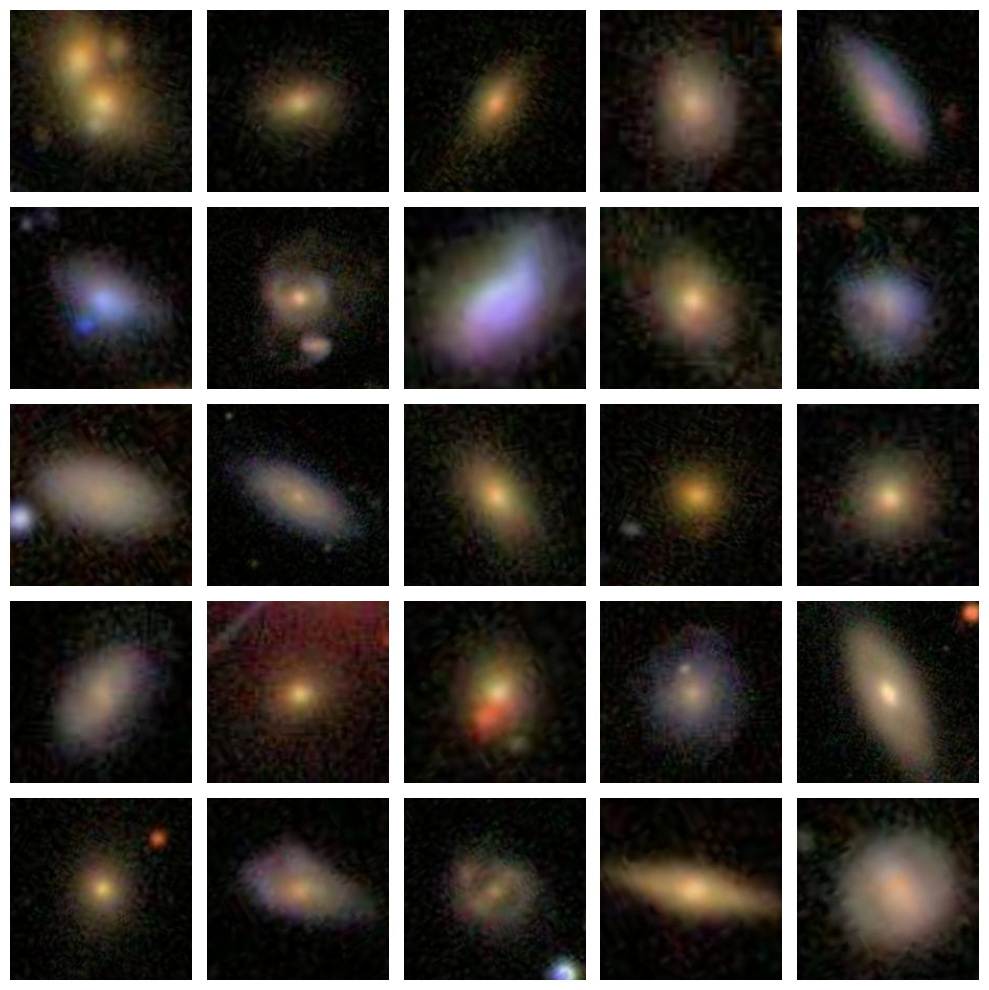

In [ ]:
# Display a 5x5 grid of randomly selected galaxy images from the training dataset

plt.figure(figsize=(10, 10))  # Set figure size for better visibility

for i in range(25):  # Loop to display 25 random images
    sample = random.randint(0, len(files_h5))  # Select a random file from the training dataset
    root_file = os.path.join(root_train, files_h5[sample])  # Get the full path of the selected file

    # Open the HDF5 file and load the galaxy image
    with h5py.File(root_file, 'r') as f:
        crop = 125  # Pixels to crop from each side
        muestra = f["galaxy"][crop:-crop, crop:-crop]  # Extract the cropped image

    # Get image dimensions
    h, w, c = muestra.shape
    img_plana = h * w * c  # Compute flattened image size
    batch_size = 100  # Define batch size for Incremental PCA

    # Initialize Incremental PCA with 75 components
    ipca = IncrementalPCA(n_components=75, batch_size=batch_size)

    # Plot the image in a 5x5 grid
    plt.subplot(5, 5, i + 1)
    plt.imshow(muestra)
    plt.axis('off')  # Remove axis for better visualization

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('galaxies.jpg')  # Save the figure as an image
plt.show()  # Display the plot


## Training

In [ ]:
# Measure the start time for performance tracking
start_time = time.time()
total_file = len(files_h5)  # Total number of files to process

train_data = []  # List to store the final transformed dataset
batch = []  # Temporary batch for batch-wise processing

# Iterate over all HDF5 files in the training dataset
for i, img in enumerate(files_h5):
    root_file = os.path.join(root_train, img)  # Get the full file path

    # Open the HDF5 file and extract the galaxy image
    with h5py.File(root_file, 'r') as f:
        crop = 125                                                            # Number of pixels to crop from each side
        image = f["galaxy"][crop:-crop, crop:-crop].astype(np.float32) / 255  # Normalize image
        batch.append(image.reshape(1, -1))                                    # Flatten and store image in batch

    # Process the batch using Incremental PCA when batch size is reached
    if len(batch) == batch_size:
        batch_array = np.vstack(batch)    # Convert batch to a 2D NumPy array
        ipca.partial_fit(batch_array)     # Train Incremental PCA with the batch
        batch = []                        # Reset batch for the next iteration

    # Display progress update every batch_size iterations
    if (i + 1) % batch_size == 0:
        delta_t = time.time() - start_time                                    # Calculate elapsed time
        print(f'Progress: {np.round((i + 1) / total_file * 100, 2)}%')
        print(f'Elapsed time: {delta_t:.2f} s\n')
        batch.append(image.reshape(1, -1))                                    # Ensure last image is included in batch processing

# Transform the entire dataset using the trained Incremental PCA model
for img in files_h5:
    with h5py.File(os.path.join(root_train, img), 'r') as f:
        image = f["galaxy"][crop:-crop, crop:-crop].astype(np.float32) / 255  # Normalize
        transformed = ipca.transform(image.reshape(1, -1))                    # Apply PCA transformation
        train_data.append(transformed)                                        # Store transformed data

# Convert the final transformed dataset into a 2D NumPy array
train_data = np.vstack(train_data)


# Scaler data

In [ ]:
# Standardize the transformed dataset using StandardScaler
scaler = StandardScaler()                             # Initialize the scaler
Scaler_train_data = scaler.fit_transform(train_data)  # Apply standardization


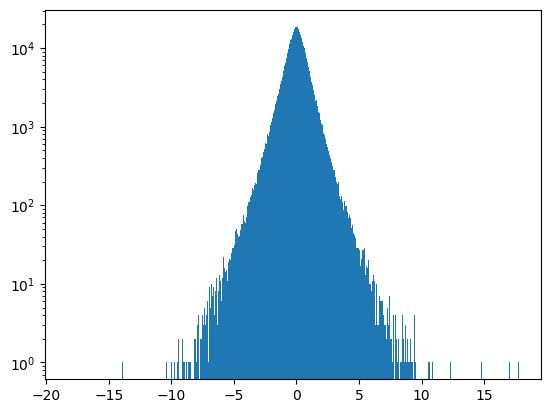

In [ ]:
# Histogram of the calculated data
# Sanity check
plt.semilogy()
plt.hist(Scaler_train_data.flatten(),bins=int(np.sqrt(len(Scaler_train_data.flatten()))))
plt.show()

#Save models

In [ ]:
# Saves data preprocessing models
joblib.dump(ipca,'/content/drive/MyDrive/Practicas_Profesionales/Codes/Models/Pre-processing/reduce_dimensions.pkl')
joblib.dump(scaler,'/content/drive/MyDrive/Practicas_Profesionales/Codes/Models/Pre-processing/scaler.pkl')

['/content/drive/MyDrive/Practicas_Profesionales/Codes/Models/Pre-processing/scaler.pkl']

# Test models

## Load models

In [ ]:
# Load preprocessing models
ipca = joblib.load('/content/drive/MyDrive/Practicas_Profesionales/Codes/Models/Pre-processing/reduce_dimensions.pkl')
scaler = joblib.load('/content/drive/MyDrive/Practicas_Profesionales/Codes/Models/Pre-processing/scaler.pkl')

## Load Data

In [ ]:
train_data = load_data(root_train)

Progress: 1.00%
Execution time: 3.04s

Progress: 2.00%
Execution time: 306.49s

Progress: 3.00%
Execution time: 309.13s

Progress: 4.00%
Execution time: 311.45s

Progress: 5.00%
Execution time: 314.80s



In [ ]:
test_data = load_data(root_test)

Progress: 2.00%
Execution time: 139.53s

Progress: 4.00%
Execution time: 141.95s

Progress: 6.00%
Execution time: 145.16s

Progress: 8.00%
Execution time: 148.89s

Progress: 10.00%
Execution time: 150.93s



## Reconstruir Datos

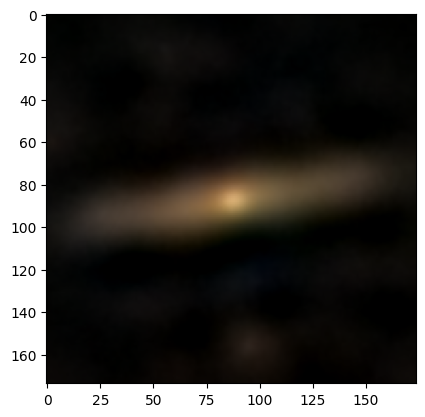

In [ ]:
# Reconstruct the original dataset using the inverse transformation from PCA
res_train_data = ipca.inverse_transform(train_data)

# Reshape the reconstructed data to match the original image dimensions (assuming 500 images)
res_train_data = res_train_data.reshape(500, 174, 174, 3)  # (num_images, height, width, channels)

# Display one of the reconstructed images
plt.imshow(res_train_data[200])  # Show the 200th image


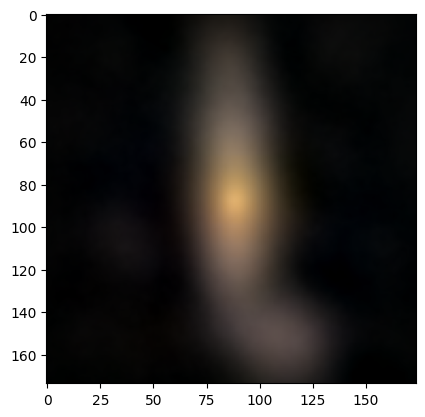

In [ ]:
res_test_data = ipca.inverse_transform(test_data)
res_test_data = res_test_data.reshape(500,174,174,3)
plt.imshow(res_test_data[435])

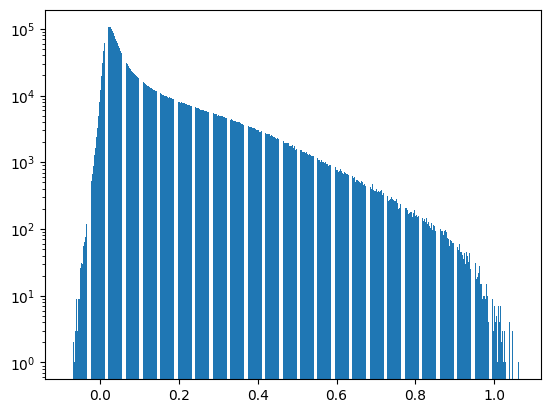

In [ ]:
# Use a semi-logarithmic scale on the y-axis for better visualization of frequency distribution
plt.semilogy()

# Plot a histogram of the flattened reconstructed training data
plt.hist(
    res_train_data.flatten(),  # Flatten the array to 1D to analyze pixel intensity distribution
    bins=int(np.sqrt(len(res_train_data.flatten()))),  # Use the square root rule for determining bin count
    rwidth=0.8  # Adjust bar width for better spacing and visibility
)

# Display the histogram
plt.show()


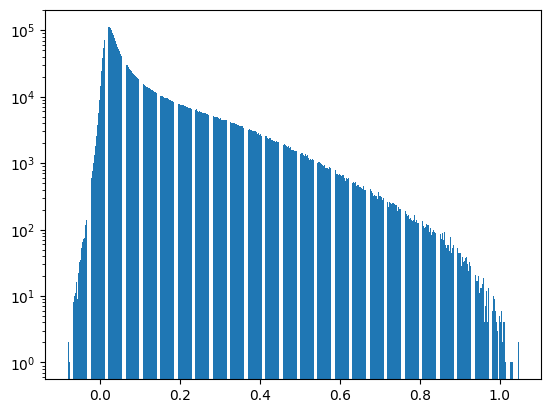

In [ ]:
# Use a semi-logarithmic scale for better visualization of the histogram
plt.semilogy()

# Plot a histogram of the flattened reconstructed test data
plt.hist(
    res_test_data.flatten(),  # Flatten the array to 1D for histogram calculation
    bins=int(np.sqrt(len(res_test_data.flatten()))),  # Use the square root rule for bin count
    rwidth=0.8  # Adjust bar width for better visibility
)

# Display the plot
plt.show()


# SAVE DATA (PKL)

Para que manejar y cargar la información de las imagenes se hace uso de archivos formatos pkl, en dichos archivos se guardaran la información reducida y escalada, es decir como imagenes de 75 pixeles

In [ ]:
# Define file paths for saving the processed training and testing datasets in pickle format (PKL)

root_train_pkl = '/content/drive/MyDrive/Practicas_Profesionales/Data/PKLs/train_data.pkl'
root_test_pkl = '/content/drive/MyDrive/Practicas_Profesionales/Data/PKLs/test_data.pkl'


In [ ]:
# Save the processed training and testing datasets as pickle (.pkl) files using joblib

joblib.dump(train_data, root_train_pkl)   # Save the PCA-transformed training data
joblib.dump(test_data, root_test_pkl)     # Save the PCA-transformed test data
